# GitHub Repository Natural Language Processing
- [GitHub Repository Natural Language Processing](#GitHub-Repository-Natural-Language-Processing)
    - [Executive Summary](#Executive-Summary)
    - [Data Acquisition](#Data-Acquisition)
    - [Wrangling](#Wrangling)
    - [Exploration](#Exploration)
        - [Distribution of languages used](#Distribution-of-languages-used)
            - [Hypothesis Testing](#Hypothesis-Testing)
        - [Does the length of the README Vary by Programming Language?](#Does-the-length-of-the-README-Vary-by-Programming-Language?)
            - [Which Languages have the longest readme's?](#Which-Languages-have-the-longest-readme's?)
            - [Median longest readme's](#Median-longest-readme's)
            - [Longest readme by Language](#Longest-readme-by-Language)
            - [Are There any Words that Uniquely Identify what Language a Readme is in?](#Are-There-any-Words-that-Uniquely-Identify-what-Language-a-Readme-is-in?)
        - [Most used words visualized](#Most-used-words-visualized)
    - [Modeling](#Modeling)
        - [Model #1: TF-IDF Bigrams Decision Tree](#Model-#1:-TF-IDF-Bigrams-Decision-Tree)
        - [Model #2: TF-IDF Logistic Regression](#Model-#2:-TF-IDF-Logistic-Regression)
        - [Model #3: TF-IDF Naïve Bayes](#Model-#3:-TF-IDF-Naïve-Bayes)
    - [Conclusions](#Conclusions)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy import stats

import re
from pprint import pprint

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import acquire as ac
import prepare as pr
import preprocessing as pp
import explore as ex
import evaluate as ev
import model as mo


import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rc('figure', figsize=(16,8))
plt.rc('font', size=14)
sns.set_palette('pastel')

---
## Executive Summary
1. Go's community values thorough documentation seemingly more than other programming language communities.
2. Some words are highly specific to a programming language (e.g. "webpack" for JavaScript).
3. Words are hard.

---
## Data Acquisition
1. First, we built a function to inspect and search a singular page of GitHub's most forked repositores and return the names of all repositores on that page.
2. Then we built a function loop through several search pages and return the repository names. This function has an added sleep timer to slow down the access rate otherwise, GitHub access rate limit would hinder the acquisition of repository names.
3. After doing some text cleaning of the repository names, all repositories were added to a list to be used in the `scrape_github_data` mother function.

---
## Wrangling

The function below does the following to each observation returned from the `scrape_github_data` mother function:
1. Reads `data.json` into a pandas DataFrame
1. Converts the DataFrame to a list of dictionaries
1. Applies some basic cleaning to the readme_contents key
1. Tokenizes each word of the clean readme contents
1. Lemmatizes each readme token
1. Removes stopwords and single character lemmas from lemmas
1. Creates a `clean_readme_contents` key (string)
1. Creates a `len_of_clean_readme_contents` key by quantifying the list of lemmas sans stopwords
1. Converts the list of dictionaries to a pandas DataFrame
1. Masks DataFrame to only include observations where the language is not null
1. Masks DataFrame to exclude lower outliers
1. Uses lambda function to exclude languages with only one observation
1. Resets DataFrame index
1. Drops original index column
1. Returns the resultant DataFrame

If you would like more information, please reference the documentation of the functions contained in the `prepare.py` library.

In [3]:
df = pr.wrangle_readme_data()
print(f"Our DataFrame contains {df.shape[0]} observations and {df.shape[1]} variables.")
df.head()

Our DataFrame contains 226 observations and 5 variables.


,repo,language,readme_contents,clean_readme_contents,len_of_clean_readme_contents
0,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...,introduction second programming assignment req...,316
1,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...,66
2,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....",div align center tensorflow image tf logo soci...,1138
3,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public repo official list smartapp...,44
4,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap getbootstrap as...,1048


---
## Exploration

### Distribution of languages used

- Using Value counts to group df by languages used

In [4]:
df_lang_count = pd.DataFrame(df.language.value_counts())

In [5]:
# 231 total observation
df_lang_count.sum()

language    226
dtype: int64

**Seems a bit sparse on some of the languages with less than 5 projects done in that language, deciding to lop all of the languages less than 5 into a bin labeled 'other'**

In [6]:
df_lang_count

,language
JavaScript,51
Java,36
Python,27
C++,16
HTML,14
Jupyter Notebook,12
Go,10
C,10
PHP,9
TypeScript,9


We're creating this function that will remove all languages with less than 5 readme's and convert those into a observation titled 'others'.

> **the languages included in 'others':
Shell, R, Vue, Groovy, Kotlin, Powershell, Rust, & C#**

In [7]:
df_lang_count = ex.get_others(df_lang_count)

In [8]:
df_lang_count.sum()

language    226
dtype: int64

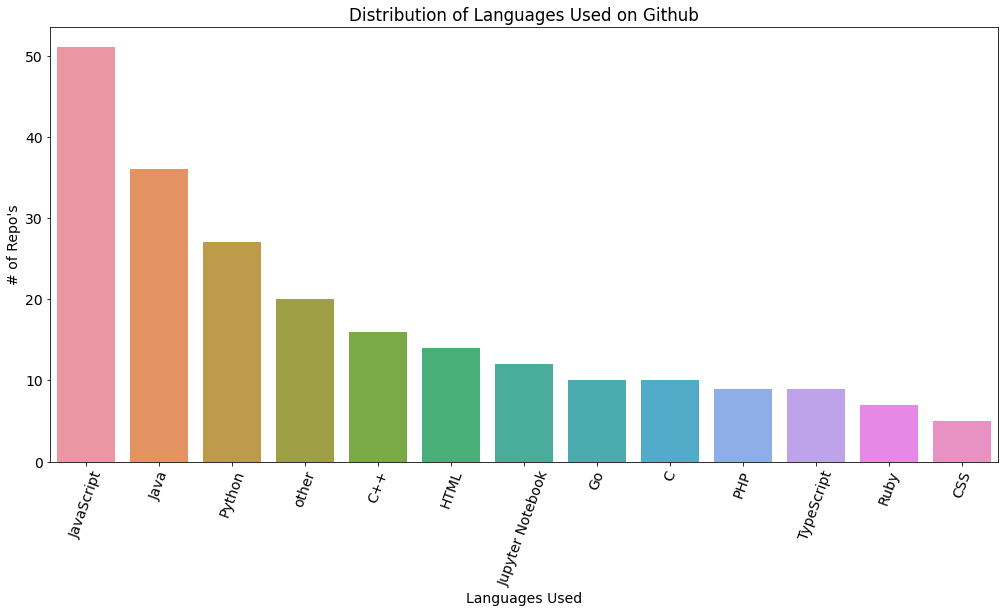

In [9]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.barplot(data=df_lang_count, x=x, y=y)

plt.title("Distribution of Languages Used on Github")
plt.ylabel('# of Repo\'s')
plt.xlabel('Languages Used')

plt.xticks(rotation=70)
plt.show()

the languages included in 'others':
Shell, R, Vue, Groovy, Kotlin, Powershell, Rust, C#, ApacheConf, Objective-C, Scala, TeX, Dart, & Rascal

#### Hypothesis Testing
- t-test:
    - $H_0$: The average amount of words used in a repo written in go is no different than the population average of words written in a readme.
    - $H_a$: The average amount of words used in a repo written in go is different than the population average of words written in a readme.

In [10]:
df.groupby('language')['len_of_clean_readme_contents'].mean()

language
C                    521.100000
C#                   280.500000
C++                  719.937500
CSS                  542.800000
Go                  2912.400000
Groovy                44.000000
HTML                 428.285714
Java                 597.416667
JavaScript          1422.294118
Jupyter Notebook     644.083333
Kotlin               446.000000
PHP                  564.555556
PowerShell           171.000000
Python              2246.814815
R                    350.666667
Ruby                 361.714286
Rust                 757.500000
Shell                490.250000
TypeScript           658.444444
Vue                 1176.333333
Name: len_of_clean_readme_contents, dtype: float64

In [11]:
go = df[df.language == 'Go']

In [12]:
t, p = stats.ttest_1samp(go.len_of_clean_readme_contents, df.len_of_clean_readme_contents.mean())

print(f't = {t:.2f}')
print(f'p = {p:.2f}')
print("Conclusion:")
a = 1 - .99
if p < a:
    print('We reject the null hypothesis')
else:
    print('We Fail to reject the null hypothesis')


t = 0.84
p = 0.42
Conclusion:
We Fail to reject the null hypothesis


### Does the length of the README Vary by Programming Language?

In [13]:
df2 = df[['language', 'clean_readme_contents']]

In [14]:
df2

,language,clean_readme_contents
0,R,introduction second programming assignment req...
1,HTML,well hello repository meant provide example fo...
2,C++,div align center tensorflow image tf logo soci...
3,Groovy,smartthings public repo official list smartapp...
4,JavaScript,align center href getbootstrap getbootstrap as...
...,...,...
221,TypeScript,ngx admin imgur omcxwz png alt eva design syst...
222,R,swirl course collection interactive course use...
223,C++,jennic platform added note detail project plea...
224,Go,etcd go report card goreportcard badge etcd io...


In [15]:
df2['cleaned_readme'] = df2.clean_readme_contents.apply(ex.clean)
df2['length_of_readme'] = df2.cleaned_readme.apply(len)

> Scatter plot where length of readme is y-axis, x-axis is how many programming languages and hue is label of programming language

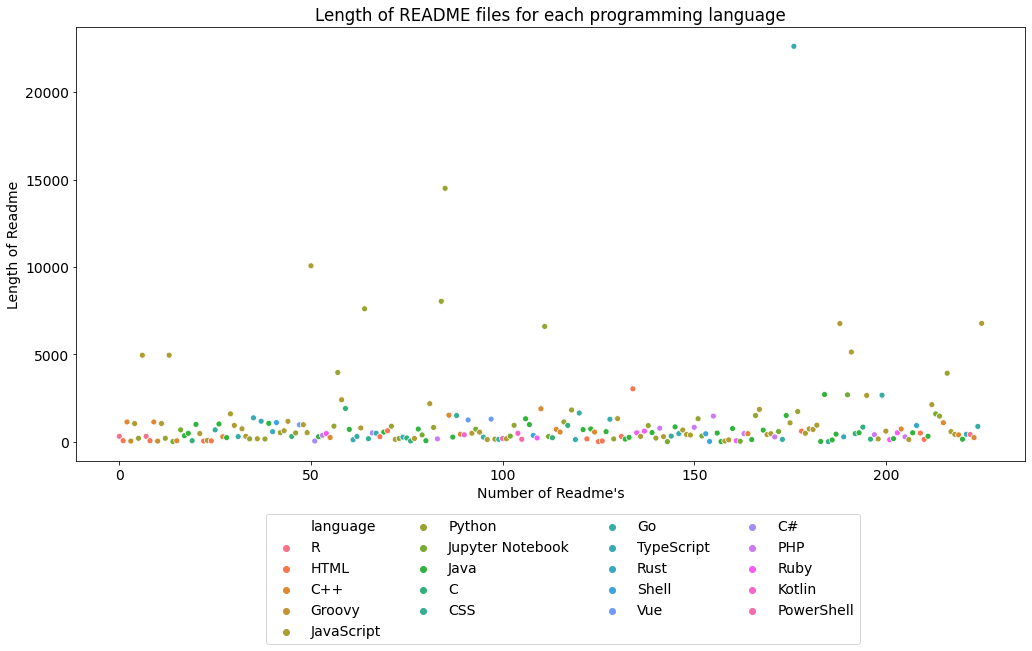

In [16]:
plt.figure(figsize=(17,8))
plt.title('Length of README files for each programming language')
x
x = df2.index
y = df2.length_of_readme
hue = df2.language
sns.scatterplot(data=df_lang_count, x=x, y=y, hue=hue)
plt.ylabel('Length of Readme')
plt.xlabel('Number of Readme\'s')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(0.2, -0.12), loc=2, borderaxespad=0., ncol=4)

plt.show()

> Length of readme's except for a few specific programming languages are below 2,000 characters. Outliers above that, include Go, python and a few others.

#### Which Languages have the longest readme's?

In [17]:
df2 = df2.sort_values(by='length_of_readme', ascending=False)
df_len = df2.groupby('language').mean()
df_len.length_of_readme

language
C                    521.100000
C#                   280.500000
C++                  719.937500
CSS                  542.800000
Go                  2912.400000
Groovy                44.000000
HTML                 428.285714
Java                 597.416667
JavaScript          1422.294118
Jupyter Notebook     644.083333
Kotlin               446.000000
PHP                  564.555556
PowerShell           171.000000
Python              2246.814815
R                    350.666667
Ruby                 361.714286
Rust                 757.500000
Shell                490.250000
TypeScript           658.444444
Vue                 1176.333333
Name: length_of_readme, dtype: float64

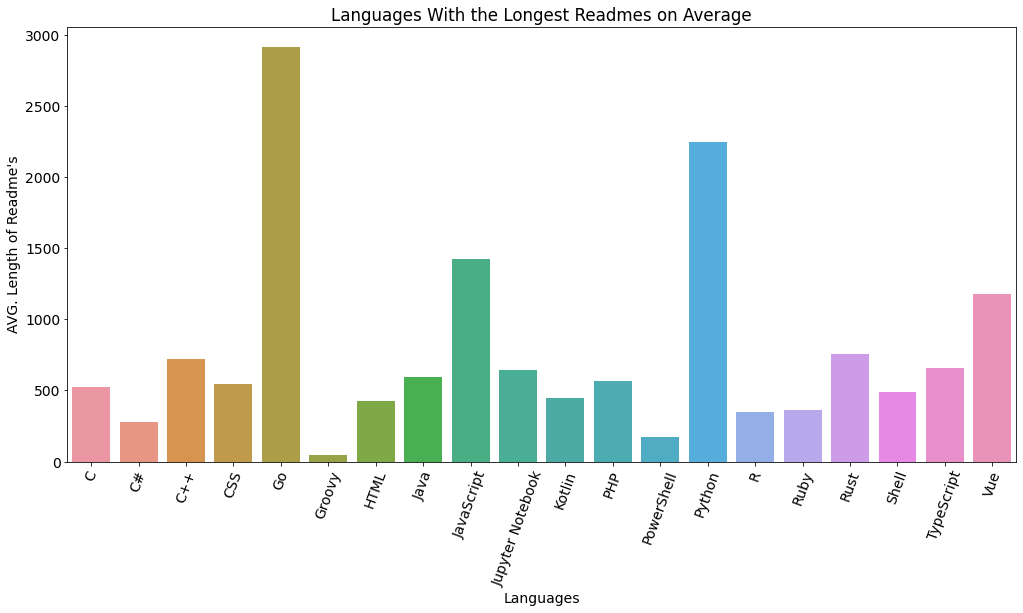

In [18]:
plt.figure(figsize=(17,8))
x = df_len.index
y = df_len.length_of_readme
sns.barplot(data=df_len, x=x, y=y)

plt.title("Languages With the Longest Readmes on Average")
plt.ylabel('AVG. Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

**Takeaways:** Average amount of words in a go readme, is greater than in any other programming language

#### Median longest readme's

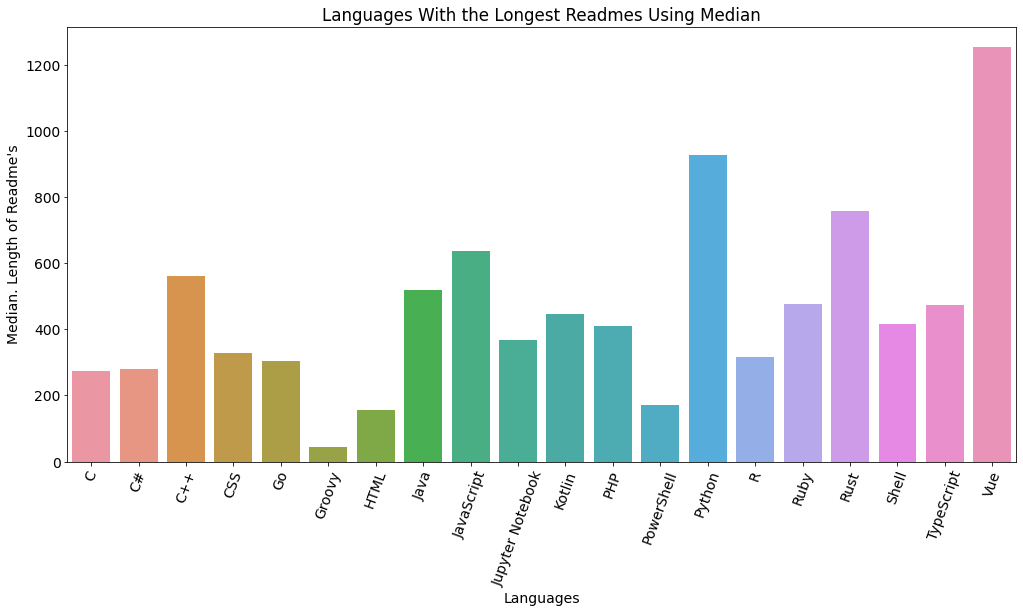

In [19]:
df_len_med = df2.groupby('language').median()

plt.figure(figsize=(17,8))
x = df_len_med.index
y = df_len_med.length_of_readme
sns.barplot(data=df_len_med, x=x, y=y)

plt.title("Languages With the Longest Readmes Using Median")
plt.ylabel('Median. Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

**Takeaways**: Vue has 2 repo's, one of them with over 1,000 words which makes up for its position in this graph.

#### Longest readme by Language

In [20]:
words_by_lang = df2.groupby('language').max()
words_by_lang = words_by_lang.sort_values(by='length_of_readme', ascending=False)
words_by_lang.length_of_readme

language
Go                  22628
Python              14505
JavaScript          10071
HTML                 3033
Java                 2710
Jupyter Notebook     2690
C                    1909
C++                  1894
CSS                  1507
PHP                  1475
TypeScript           1374
Vue                  1302
Shell                1102
Rust                  934
Ruby                  613
C#                    512
Kotlin                488
R                     420
PowerShell            193
Groovy                 44
Name: length_of_readme, dtype: int64

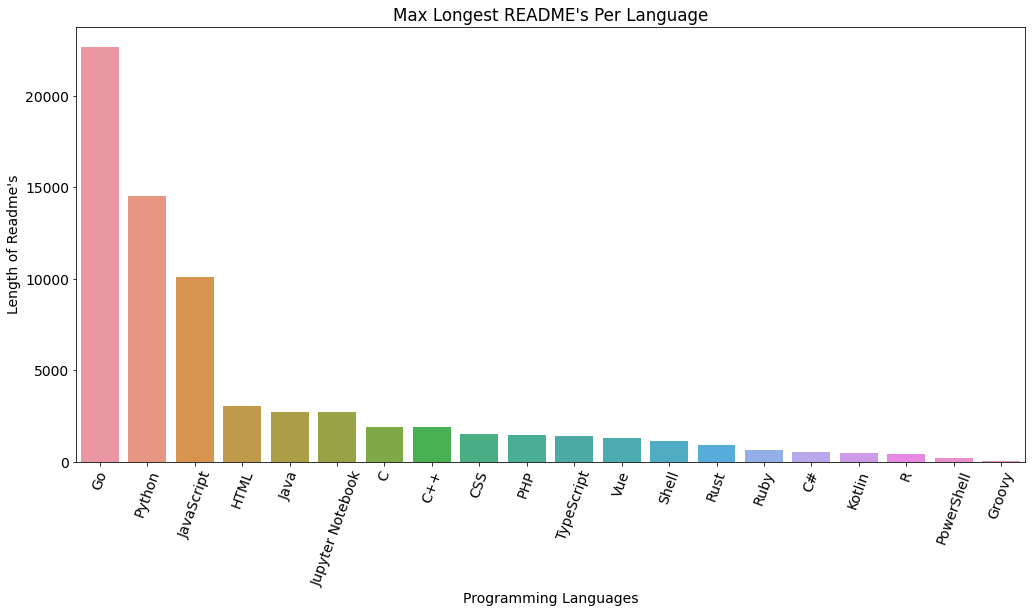

In [21]:
plt.figure(figsize=(17,8))
x = words_by_lang.index
y = words_by_lang.length_of_readme
sns.barplot(data=words_by_lang, x=x, y=y)

plt.title("Max Longest README\'s Per Language")
plt.ylabel('Length of Readme\'s')
plt.xlabel('Programming Languages')

plt.xticks(rotation=70)
plt.show()

**Takeaways**: Go, python & javascript seem to have the most documented README's in our observations

#### Are There any Words that Uniquely Identify what Language a Readme is in?
- We chose the top 3 most popular languages based on length of README's 
    - Go, Python & JavaScript 
- and we ran those against all words used    

In [22]:
go_words = ex.clean(' '.join(df2[df2.language == 'Go'].clean_readme_contents))
python_words = ex.clean(' '.join(df2[df2.language == 'Python'].clean_readme_contents))
javascript_words = ex.clean(' '.join(df2[df2.language == 'JavaScript'].clean_readme_contents))
all_words = ex.clean(' '.join(df2.clean_readme_contents))

In [23]:
go_freq = pd.Series(go_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [24]:
word_counts = (pd.concat([all_freq, go_freq, python_freq, javascript_freq], axis=1, sort=True)
              .set_axis(['all', 'go', 'python', 'javascript'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [25]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,go,python,javascript
go,1890,1701,90,47
io,1588,145,304,440
href,1377,0,108,780
python,1299,16,917,2
data,1109,95,594,239
library,1103,390,485,103
master,1070,60,168,203
code,1055,92,280,238
api,1035,155,443,255
html,1029,51,343,315


In [26]:
pd.concat([word_counts[word_counts.go == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.go == 0].sort_values(by='python').tail(6),
          word_counts[word_counts.javascript == 0].sort_values(by='go').tail(6),
          word_counts[word_counts.javascript == 0].sort_values(by='python').tail(6),
          word_counts[word_counts.python == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='go').tail(6)
          ])

,all,go,python,javascript
npm,471,0,0,365
sponsor,546,0,0,400
requireactive,524,0,0,524
webpack,735,0,0,720
opencollective,946,0,1,740
href,1377,0,108,780
title,287,0,112,21
py,206,0,138,0
transformer,140,0,140,0
ml,211,0,147,0


- Now we're going to compare the proportions of the most popular words used against our 3 most popular programming languages

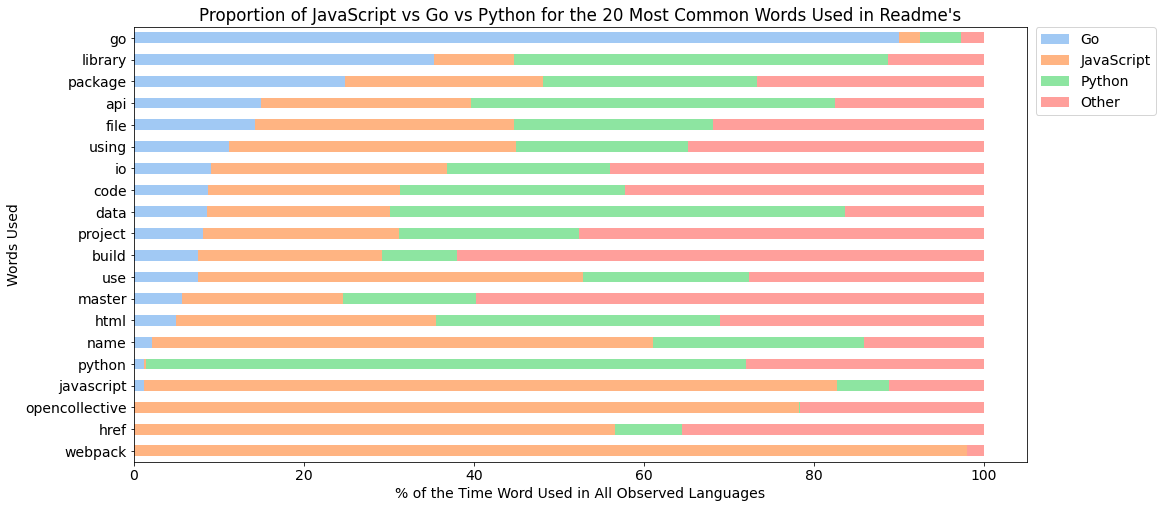

In [27]:
(word_counts
 .assign(Go=(word_counts.go / word_counts['all']) * 100,
         JavaScript=(word_counts.javascript / word_counts['all']) * 100,
        Python=(word_counts.python / word_counts['all']) * 100,
        Other=((word_counts['all'] - (word_counts.go + word_counts.python + word_counts.javascript)) / word_counts['all']) * 100)
 .sort_values(by='all')
 [['Go', 'JavaScript', 'Python', 'Other']]
 .tail(20)
 .sort_values('Go')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs Go vs Python for the 20 Most Common Words Used in Readme\'s')
plt.ylabel('Words Used')
plt.xlabel('% of the Time Word Used in All Observed Languages')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., ncol=1)
plt.show()

### Most used words visualized

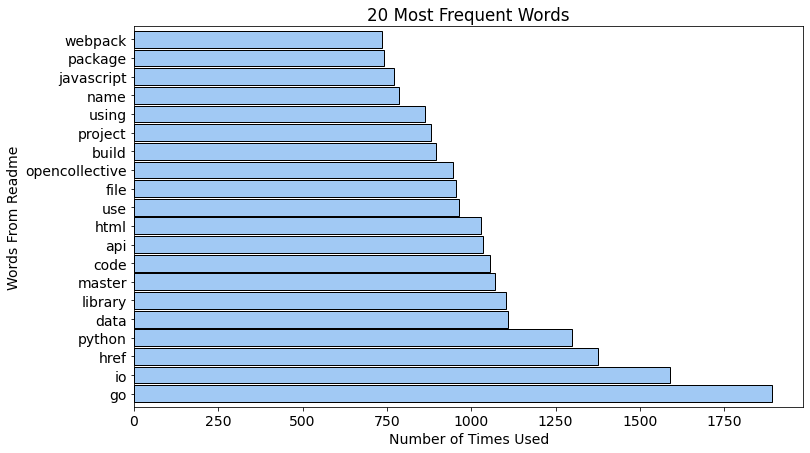

In [28]:
plt.figure(figsize=(12,7))
word_counts["all"].sort_values(ascending=False).head(20).plot.barh(width=.9, ec='black',
                                                                  title='20 Most Frequent Words')

plt.ylabel('Words From Readme')
plt.xlabel('Number of Times Used')
plt.show()


---
## Modeling

In [29]:
# create evaluation DataFrame
evaluation = pd.DataFrame(columns=["model_type", "train_accuracy", "test_accuracy"])

### Model #1: TF-IDF Bigrams Decision Tree

In [30]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(max_depth=5, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Gini, 5", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.5


This more than likely luck that the model performed better on test than train. We can find a better model.

In [31]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(max_depth=6, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Gini, 6", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261


In [32]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Entropy, 6", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783


### Model #2: TF-IDF Logistic Regression

In [33]:
# create tfidf vectorizer object
tfidf = TfidfVectorizer()

# use tfidf object to create model features
X = tfidf.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
logit = LogisticRegression(random_state=56)

# fit model object
logit.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Logistic Regression", model_object=logit, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783


### Model #3: TF-IDF Naïve Bayes

In [34]:
# create tfidf vectorizer object
tfidf = TfidfVectorizer()

# use tfidf object to create model features
X = tfidf.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
nb = MultinomialNB()

# fit model object
nb.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Naïve Bayes", model_object=nb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783
4,TF-IDF Naïve Bayes,0.450000,0.413043


In [35]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Entropy, 10", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783
4,TF-IDF Naïve Bayes,0.450000,0.413043
5,"TF-IDF Bigrams Entropy, 10",0.805556,0.369565


In [36]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(criterion="entropy", random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Entropy", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783
6,TF-IDF Bigrams Entropy,1.000000,0.434783
4,TF-IDF Naïve Bayes,0.450000,0.413043
5,"TF-IDF Bigrams Entropy, 10",0.805556,0.369565


In [37]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(1, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(criterion="entropy", max_depth=15, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Unigrams & Bigrams Entropy, 15", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
7,"TF-IDF Unigrams & Bigrams Entropy, 15",1.000000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783
6,TF-IDF Bigrams Entropy,1.000000,0.434783
4,TF-IDF Naïve Bayes,0.450000,0.413043
5,"TF-IDF Bigrams Entropy, 10",0.805556,0.369565


---
## Conclusions
1. The Go, Python, and JavaScript communities value documentation more than any other programming language communities.
1. Some words can uniquely identify or be used to predict a programming language.
1. When it comes to quantifying language, there's lots of room for improvement.